ResNet18, 34, 50, VIP, MVP, DINO


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path

import zarr

import torch
import numpy as np
import matplotlib.pyplot as plt

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)

Device: cuda


In [4]:
from src.models.encoders import models

**All Files Loading Info**


In [5]:
# NOTE: Change this to wherever the project is located in your google drive
project_root = Path(".").resolve().parent
# project_root = Path("/content/drive/MyDrive/17 – Research/sim-2-real-representation-learning") # Lars
data_path = project_root / "data" / "processed"
models_path = project_root / "models"
embeddings_path = project_root / "embeddings"

print("Project root:", project_root)
print("Data path:", data_path)
print("Models path:", models_path)
print("Embeddings path:", embeddings_path)

Project root: /home/ubuntu/semrep
Data path: /home/ubuntu/semrep/data/processed
Models path: /home/ubuntu/semrep/models
Embeddings path: /home/ubuntu/semrep/embeddings


In [6]:
# Load the data
sim2 = zarr.open(data_path / "one_leg_med_sim.zarr", mode="r")
real = zarr.open(data_path / "one_leg_low_real.zarr", mode="r")
sim2_imgs = sim2["color_image2"]
real_imgs = real["color_image2"]
sim2_labels = sim2["action/pos"]
real_labels = real["action/pos"]


print(f"Loaded {len(sim2['episode_ends'])} trajectories containing {sim2_imgs.shape[0]} frames")
print(f"Loaded {len(real['episode_ends'])} trajectories containing {real_imgs.shape[0]} frames")

Loaded 50 trajectories containing 24131 frames
Loaded 50 trajectories containing 27699 frames


KeyboardInterrupt: 

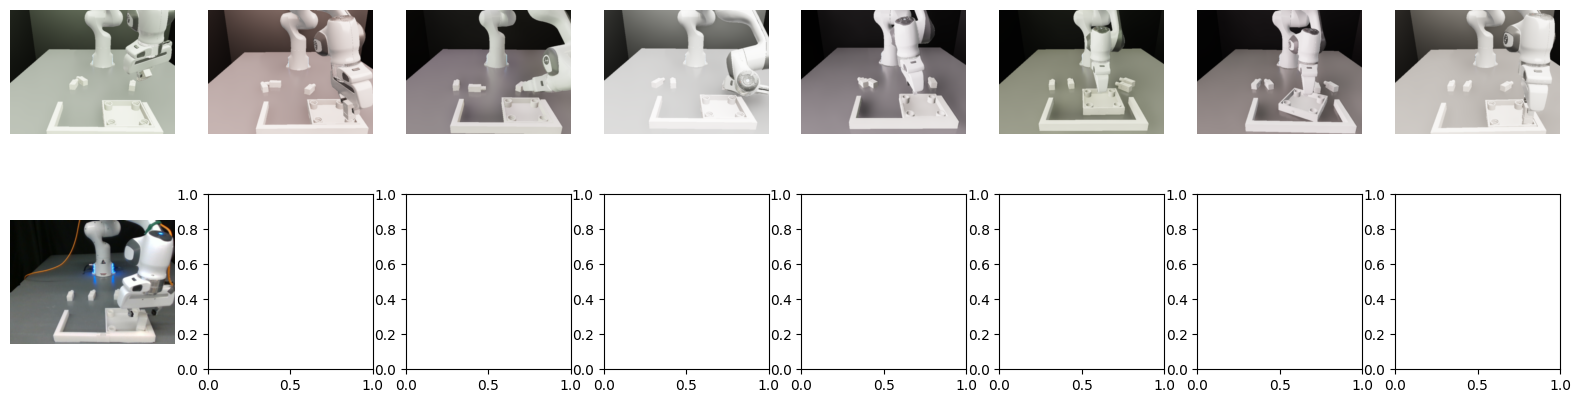

In [6]:
# Sample 8 images from each dataset
sim2_indices = np.random.choice(sim2_imgs.shape[0], size=8, replace=False)
real_indices = np.random.choice(real_imgs.shape[0], size=8, replace=False)

# Create a figure and axes
fig, axes = plt.subplots(2, 8, figsize=(20, 5))

# # Display the sampled images
# for i, idx in enumerate(sim1_indices):
#     axes[0, i].imshow(sim1_imgs[idx])
#     axes[0, i].axis("off")

for i, idx in enumerate(sim2_indices):
    axes[1 - 1, i].imshow(sim2_imgs[idx])
    axes[1 - 1, i].axis("off")

for i, idx in enumerate(real_indices):
    axes[2 - 1, i].imshow(real_imgs[idx])
    axes[2 - 1, i].axis("off")

plt.tight_layout()
plt.show()

**Load Models**


In [24]:
# Choose the model to use
selected_model_name = "ResNet18"  # Change this to the desired model's name

# Load the selected model
model = models[selected_model_name]().cuda()
model.eval()

/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/r3m/__init__.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly

R3M(
  (cs): CosineSimilarity()
  (bce): BCELoss()
  (sigm): Sigmoid()
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): B

### Example of loading our own custom weights

I've trained some models on the data that we've visualized above (the real and the nicely rendered sets). Here, I'll show an example of how we can load up our own weights, and I'd be really curious to see how these embeddings might be different to the pre-trained encoders.


**Output Dimensions**


In [9]:
def output():
    if selected_model_name == "MVP" or selected_model_name == "VIP":
        random_input = torch.rand((1, 3, 224, 224)).to(device)  # Move to the correct device
    else:
        random_input = (
            torch.randint(0, 255, size=(1, 3, 224, 224)).float().to(device) / 255.0
        )  # Convert to float and move to device

    # Pass the random data through the encoder
    with torch.no_grad():
        output = model(random_input)

    return output


model_output_dim = output()

**TSNE**


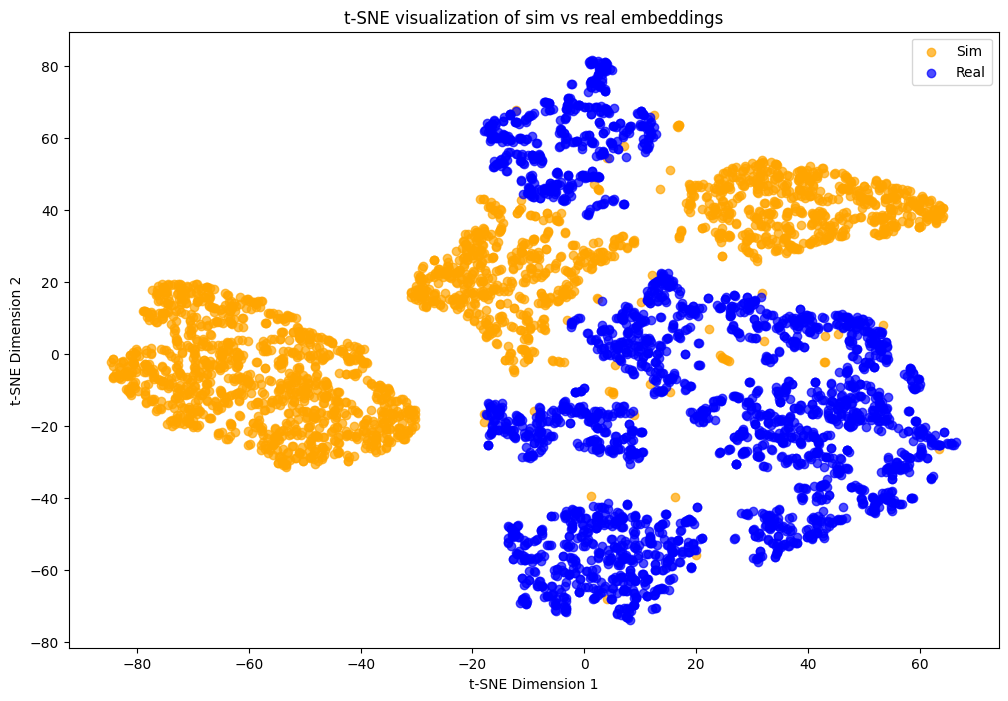

In [36]:
from src.models.tsne import plot_tsne

file_path = embeddings_path / "encoders/ResNet18.npz"

# Sample a subset of the data
n_samples = 5000
dataset = np.load(file_path)


indices = np.random.choice(len(dataset["embeddings"]), n_samples, replace=False)

embeddings = dataset["embeddings"][indices]
domain_labels = dataset["dataset_flag"][indices]

# Plot t-SNE
plot_tsne(embeddings, domain_labels)

**Grad-CAM for one image**


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import RawScoresOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from r3m import load_r3m

# Load image
image = sim2["color_image2"][0]  # choose index

model = load_r3m("resnet18").cuda()
model.eval()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Grad-CAM setup
target_layers = [model.module.convnet.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

def generate_gradcam(image):
    
    input_tensor = transform(image).unsqueeze(0)
    targets = [RawScoresOutputTarget()]  
    
    
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]  
    
    
    if grayscale_cam.ndim > 2:
        grayscale_cam = grayscale_cam[0]  
    
    original_size = (image.shape[0], image.shape[1])  
    heatmap_resized = cv2.resize(grayscale_cam, (original_size[1], original_size[0]))  

    
    heatmap_resized = np.interp(heatmap_resized, (heatmap_resized.min(), heatmap_resized.max()), (0, 1))  

    
    rgb_img = np.float32(image) / 255  
    visualization = show_cam_on_image(rgb_img, heatmap_resized, use_rgb=True)
    
    return visualization

gradcam_img = generate_gradcam(image)

# Display the original image and Grad-CAM
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(np.float32(image) / 255)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(gradcam_img)
axes[1].set_title('Grad-CAM')
axes[1].axis('off')

plt.tight_layout()
plt.show()


/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/r3m/__init__.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly

RuntimeError: grad can be implicitly created only for scalar outputs

**gradcam and tsne analysis of 5 furthest and closest images**

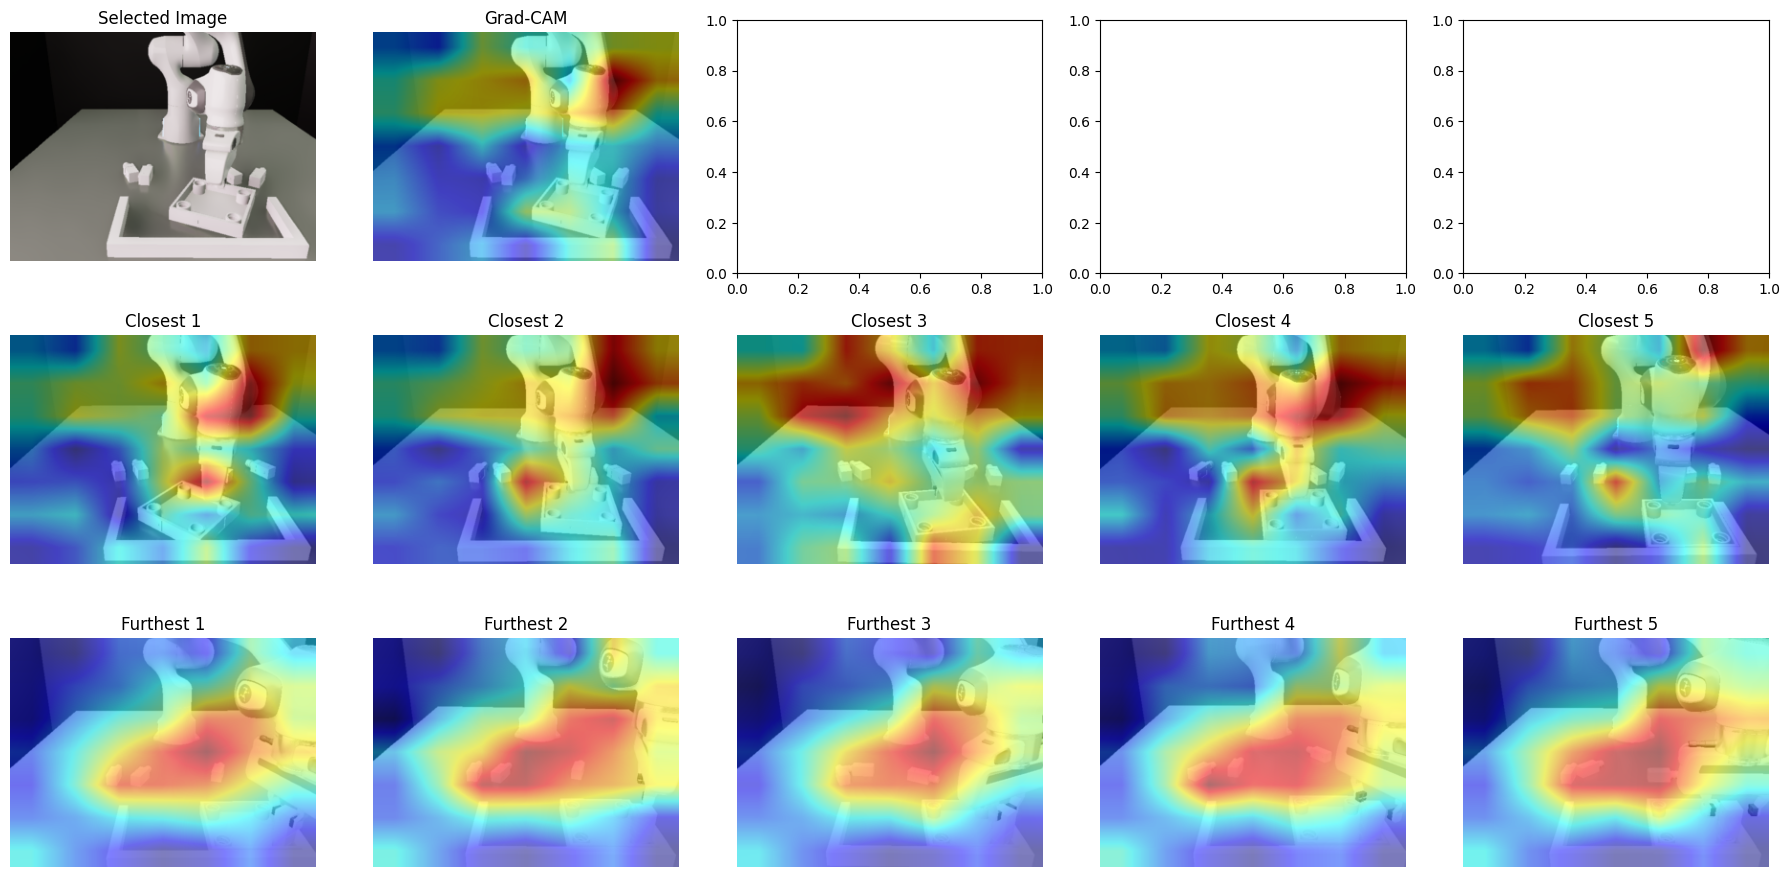

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
from torchvision import models, transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Load image
image = sim2["color_image2"][0]  

model = models.resnet18()
model.eval()

# Define transformation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

def generate_gradcam(image):
    
    input_tensor = transform(image).unsqueeze(0)
    targets = [ClassifierOutputTarget(281)]
    
    # Generate the Grad-CAM heatmap
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
    
    if grayscale_cam.ndim > 2:
        grayscale_cam = grayscale_cam[0]  
    
    
    original_size = (image.shape[0], image.shape[1])  # image is (H, W, C)
    heatmap_resized = cv2.resize(grayscale_cam, (original_size[1], original_size[0]))  # Resize to original size

    
    heatmap_resized = np.interp(heatmap_resized, (heatmap_resized.min(), heatmap_resized.max()), (0, 1))  # Normalize to [0, 1]

    
    rgb_img = np.float32(image) / 255  
    visualization = show_cam_on_image(rgb_img, heatmap_resized, use_rgb=True)
    
    return visualization

file_path = embeddings_path / "encoders/ResNet18.npz"
dataset = np.load(file_path)
embeddings = dataset["embeddings"]
domain_labels = dataset["dataset_flag"]


n_samples = 5000
indices = np.random.choice(len(embeddings), n_samples, replace=False)


selected_index = 57  # choose image index
selected_embedding = embeddings[selected_index]

distances = np.linalg.norm(embeddings - selected_embedding, axis=1)


closest_indices = np.argsort(distances)[1:6]  
furthest_indices = np.argsort(distances)[-5:]  

# Generate Grad-CAM for the selected image and its closest and furthest images
gradcam_images = []
for index in [selected_index] + closest_indices.tolist() + furthest_indices.tolist():
    gradcam_img = generate_gradcam(sim2["color_image2"][index])  
    gradcam_images.append(gradcam_img)


fig, axes = plt.subplots(3, 5, figsize=(18, 9))
axes[0, 0].imshow(np.float32(sim2["color_image2"][selected_index]) / 255)
axes[0, 0].set_title('Selected Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(gradcam_images[0])
axes[0, 1].set_title('Grad-CAM')
axes[0, 1].axis('off')


for i, index in enumerate(closest_indices):
    axes[1, i].imshow(gradcam_images[i + 1]) 
    axes[1, i].set_title(f'Closest {i + 1}')
    axes[1, i].axis('off')


for i, index in enumerate(furthest_indices):
    axes[2, i].imshow(gradcam_images[len(closest_indices) + 1 + i])
    axes[2, i].set_title(f'Furthest {i + 1}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()


**Action Probing**

Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[-0.0083, -0.0111,  1.7402,  ...,  0.0089,  2.5208,  0.0140],
        [-0.0084, -0.0112,  1.7224,  ...,  0.0089,  2.4758,  0.0140],
        [-0.0082, -0.0111,  1.7682,  ...,  0.0089,  2.5306,  0.0140],
        [-0.0083, -0.0111,  1.7500,  ...,  0.0089,  2.5061,  0.0140],
        [-0.0082, -0.0111,  1.7753,  ...,  0.0089,  2.5331,  0.0140]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e-01,  4.9741e-01,  8.6570e-01,
         -5.6155e-02,  8.6084e-01, -5.0056e-01, -9.1579e-02, -1.0000e+00],
        [ 5.2736e-01, -5.1224e-03,  1.2181e-01,  4.9747e-01,  8.6566e-01,
         -5.6259e-02,  8.6079e-01, -5.0063e-01, -9.1679e-02, -1.0000e+00],
     

Training Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1000, 10])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([432, 10])) that is different to the input size (torch.Size([432, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([398, 10])) that is different to the input size (torch.Size(

Average Training Loss (Last 100 Epochs): 0.3142
Plots saved to /home/ubuntu/semrep/src/models/train_val_loss_separate_smoothed.png


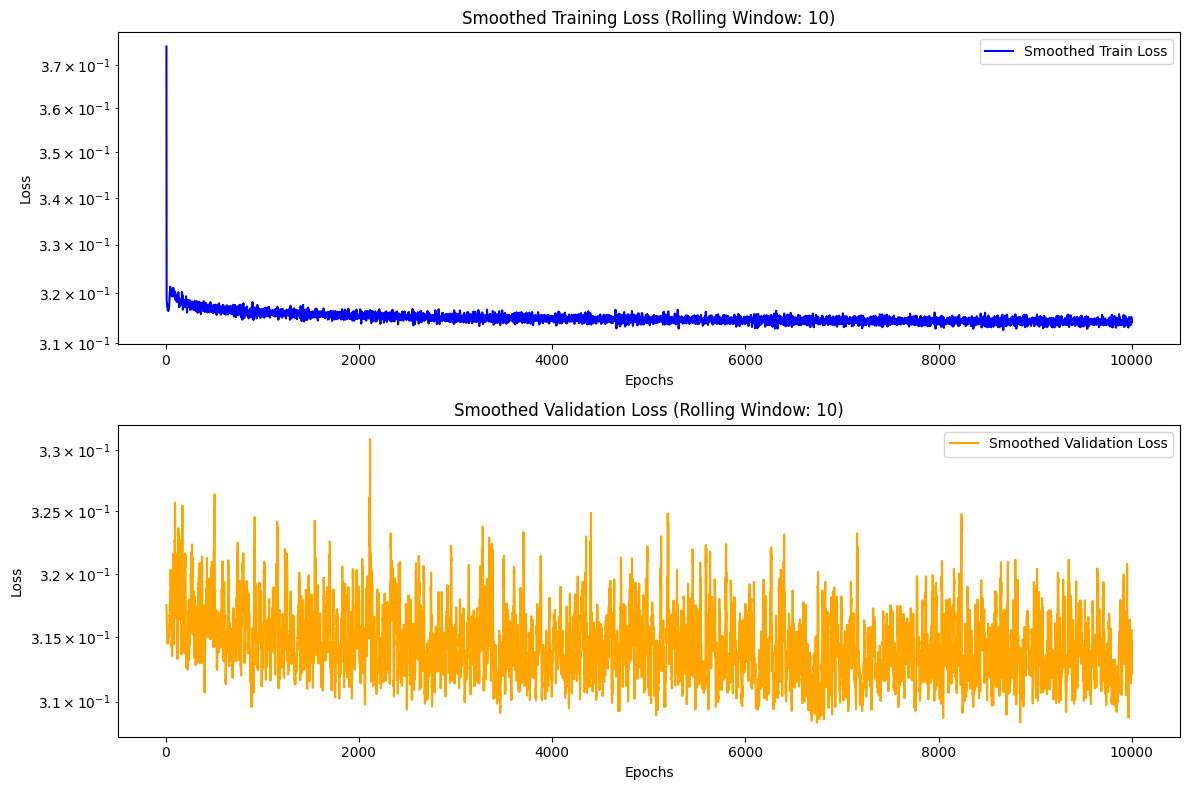

In [7]:
from src.models.actionprobe import train_action_probe

file_path = embeddings_path / "encoders/VIP.npz"

# lr = 0.01
# small batch = 100
# big batch = 1000
# epochs 100/10000
train_action_probe(file_path, epochs=10000, batch_size=1000, lr=0.01)


**Domain Probing**


In [ ]:
from src.models.domainprobe import train_domain_probe

file_path = embeddings_path / "encoders/ResNet50.npz"

train_domain_probe(file_path, epochs=30)

Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[0.0000, 0.0000, 0.0346,  ..., 0.2116, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0310,  ..., 0.2045, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0345,  ..., 0.2111, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0336,  ..., 0.2098, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0351,  ..., 0.2129, 0.0000, 0.0000]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Epoch [1/30] | Train Loss: 0.6382 | Val Loss: 0.5921 | Val Accuracy: 76.65%
Epoch [2/30] | Train Loss: 0.5707 | Val Loss: 0.5456 | Val Accuracy: 77.56%
Epoch [3/30] | Train Loss: 0.5389 | Val Loss: 0.5193 | Val Accuracy: 79.88%
Epoch [4/30] | Train Loss: 0.5215 | Val Loss: 0.5067 | Val Accuracy: 79.29%
Epoch [5/30] | Train Loss: 0.5098 | Val Loss: 0.4953 | Val Accuracy: 79.99%
Epoch [6/30] |

**Domain Labels Alternative**


In [14]:
from src.models.domain_labels_r2 import domain_r_squared
from src.models.loadsplit import load_and_use_existing_split

file_path = "/home/ubuntu/semrep/embeddings/encoders/ResNet18.npz"


train_data, val_data = load_and_use_existing_split(file_path)

dataset = np.load(file_path)
embeddings = dataset["embeddings"]

domain_r_squared(embeddings, dataset["dataset_flag"])

12355072
R^2 value: 0.9960977503146864


In [15]:
from src.models.centroid_distance import euclidean_distance, cosine_distance


file_path = "/home/ubuntu/semrep/embeddings/encoders/dinov2.npz"

dataset = np.load(file_path)
embeddings = dataset["embeddings"]

print(embeddings.shape)

euclidean_distance(embeddings, dataset["dataset_flag"])


ImportError: cannot import name 'euclidean_distance' from 'src.models.centroid_distance' (/home/ubuntu/semrep/src/models/centroid_distance.py)